In [1]:
# mentioning datatypes for better documentation
from typing import Dict, List
from datasets import Dataset, load_dataset, disable_caching
disable_caching() ## disable huggingface cache
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import Dataset
from IPython.display import Markdown

**Dataset Definition**

In [2]:
# Dataset Preparation
dataset = load_dataset("MBZUAI/LaMini-instruction" , split = 'train') 
small_dataset = dataset.select([i for i in range(200)])
print(small_dataset)
print(small_dataset[0])

# creating templates
prompt_template = """Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: {instruction}\n Response:"""
answer_template = """{response}"""

# creating function to add keys in the dictionary for prompt, answer and whole text
def _add_text(rec):
    instruction = rec["instruction"]
    response = rec["response"] 
    # check if both exists, else raise error   
    if not instruction:
        raise ValueError(f"Expected an instruction in: {rec}")
    if not response:
        raise ValueError(f"Expected a response in: {rec}")
    rec["prompt"] = prompt_template.format(instruction=instruction)
    rec["answer"] = answer_template.format(response=response)
    rec["text"] = rec["prompt"] + rec["answer"]
    return rec

# running through all samples
small_dataset = small_dataset.map(_add_text)
for i in range(0, 5):
    print(f"\nInput {i}:")
    for key, value in small_dataset[i].items():
        print(f"\t{key}: {value}")

Dataset({
    features: ['instruction', 'response', 'instruction_source'],
    num_rows: 200
})
{'instruction': 'List 5 reasons why someone should learn to code', 'response': '1. High demand for coding skills in the job market\n2. Increased problem-solving and analytical skills\n3. Ability to develop new products and technologies\n4. Potentially higher earning potential\n5. Opportunity to work remotely and/or freelance', 'instruction_source': 'alpaca'}


Map:   0%|          | 0/200 [00:00<?, ? examples/s]


Input 0:
	instruction: List 5 reasons why someone should learn to code
	response: 1. High demand for coding skills in the job market
2. Increased problem-solving and analytical skills
3. Ability to develop new products and technologies
4. Potentially higher earning potential
5. Opportunity to work remotely and/or freelance
	instruction_source: alpaca
	prompt: Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: List 5 reasons why someone should learn to code
 Response:
	answer: 1. High demand for coding skills in the job market
2. Increased problem-solving and analytical skills
3. Ability to develop new products and technologies
4. Potentially higher earning potential
5. Opportunity to work remotely and/or freelance
	text: Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: List 5 reasons why someone should learn to code
 Response:1. High demand for codi

**Model Definition**

In [3]:
from transformers import BitsAndBytesConfig

# loading the tokenizer for dolly model. The tokenizer converts raw text into tokens
model_id = "databricks/dolly-v2-3b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

#loading the model using AutoModelForCausalLM
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # use_cache=False,
    device_map="auto", #"balanced",
    quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    torch_dtype=torch.float16
)

# resizes input token embeddings matrix of the model if new_num_tokens != config.vocab_size.
base_model.resize_token_embeddings(len(tokenizer))

Embedding(50280, 2560)

In [4]:
from functools import partial
import copy
from transformers import DataCollatorForSeq2Seq

MAX_LENGTH = 256

# Function to generate token embeddings from text part of batch
def _preprocess_batch(batch: Dict[str, List]):  
    model_inputs = tokenizer(batch["text"], max_length=MAX_LENGTH, truncation=True, padding='max_length')    
    model_inputs["labels"] = copy.deepcopy(model_inputs['input_ids'])
    return model_inputs

_preprocessing_function = partial(_preprocess_batch)

# apply the preprocessing function to each batch in the dataset
encoded_small_dataset = small_dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["instruction", "response", "prompt", "answer"],
)
processed_dataset = encoded_small_dataset.filter(lambda rec: len(rec["input_ids"]) <= MAX_LENGTH)

# splitting dataset
split_dataset = processed_dataset.train_test_split(test_size=14, seed=0)
print(split_dataset)

# takes a list of samples from a Dataset and collate them into a batch, as a dictionary of PyTorch tensors.
data_collator = DataCollatorForSeq2Seq(
        model = base_model, tokenizer=tokenizer, max_length=MAX_LENGTH, pad_to_multiple_of=8, padding='max_length')

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction_source', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 186
    })
    test: Dataset({
        features: ['instruction_source', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14
    })
})


In [5]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

LORA_R = 256 # 512
LORA_ALPHA = 512 # 1024
LORA_DROPOUT = 0.05
# Define LoRA Config
lora_config = LoraConfig(
                 r = LORA_R, # the dimension of the low-rank matrices
                 lora_alpha = LORA_ALPHA, # scaling factor for the weight matrices
                 lora_dropout = LORA_DROPOUT, # dropout probability of the LoRA layers
                 bias="none",
                 task_type="CAUSAL_LM",
                 target_modules=["query_key_value"],
)

# Prepare int-8 model for training - utility function that prepares a PyTorch model for int8 quantization training. <https://huggingface.co/docs/peft/task_guides/int8-asr>
model = prepare_model_for_kbit_training(base_model, 8)
# initialize the model with the LoRA framework
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 83,886,080 || all params: 2,858,972,160 || trainable%: 2.9341


**Training using Trainer Class**

In [6]:
# from transformers import TrainingArguments, Trainer
# import bitsandbytes
# # define the training arguments first.
# EPOCHS = 1
# LEARNING_RATE = 1e-4  
# MODEL_SAVE_FOLDER_NAME = "dolly-3b-lora"
# training_args = TrainingArguments(
#                     output_dir=MODEL_SAVE_FOLDER_NAME,
#                     overwrite_output_dir=True,
#                     fp16=True, #converts to float precision 16 using bitsandbytes
#                     per_device_train_batch_size=1,
#                     per_device_eval_batch_size=1,
#                     learning_rate=LEARNING_RATE,
#                     num_train_epochs=EPOCHS,
#                     logging_strategy="epoch",
#                     evaluation_strategy="epoch",
#                     save_strategy="epoch",
# )
# # training the model 
# trainer = Trainer(
#         model=model,
#         tokenizer=tokenizer,
#         args=training_args,
#         train_dataset=split_dataset['train'],
#         eval_dataset=split_dataset["test"],
#         data_collator=data_collator,
# )
# model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
# trainer.train()
# # only saves the incremental 🤗 PEFT weights (adapter_model.bin) that were trained, meaning it is super efficient to store, transfer, and load.
# trainer.model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
# # save the full model and the training arguments
# trainer.save_model(MODEL_SAVE_FOLDER_NAME)
# trainer.model.config.save_pretrained(MODEL_SAVE_FOLDER_NAME)

**Custom Training Loop**

In [7]:
# import torch.nn.functional as F

# # Example custom loss function
# def custom_loss(outputs, labels):
#     # Mean Squared Error as an example
#     return F.mse_loss(outputs, labels)

# from torch.utils.data import DataLoader
# from tqdm import tqdm

# EPOCHS = 1
# LEARNING_RATE = 1e-4  
# MODEL_SAVE_FOLDER_NAME = "dolly-3b-lora"

# # Define your optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# # Create DataLoader for train and test datasets
# train_loader = DataLoader(split_dataset['train'], batch_size=1, shuffle=True)
# eval_loader = DataLoader(split_dataset['test'], batch_size=1)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Training loop
# for epoch in range(EPOCHS):
#     model.train()  # Set model to training mode
#     train_loss = 0.0
    
#     for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{EPOCHS}"):
#         print("AAAAAA")
#         for k, v in batch.items():
#             print(f"{k}: {v}")
#         print("BBBBBB")
#         inputs = {}
#         # Move batch data to device
#         for key, list_value in batch.items():
#             print(f"{key}: {list_value}")
#             # if values are not tensor pass
#             if not isinstance(list_value, torch.Tensor):
#                 inputs[key] = {key: list_value}
#             else:
#                 inputs[key] = {key: [value.to(device) for value in list_value]}

#         # inputs = {k: v.to(device) for k, v in batch.items()}

#         # Forward pass
#         outputs = model(**inputs)
#         loss = custom_loss(outputs.logits, inputs["labels"])  # Use your custom loss here

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
    
#     print(f"Epoch {epoch + 1} - Training Loss: {train_loss / len(train_loader)}")

#     # Evaluation loop
#     model.eval()  # Set model to evaluation mode
#     eval_loss = 0.0
#     with torch.no_grad():
#         for batch in tqdm(eval_loader, desc="Evaluating"):
#             inputs = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**inputs)
#             loss = custom_loss(outputs.logits, inputs["labels"])  # Use the same custom loss
#             eval_loss += loss.item()
    
#     print(f"Epoch {epoch + 1} - Evaluation Loss: {eval_loss / len(eval_loader)}")

# # Save the trained model
# model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
# tokenizer.save_pretrained(MODEL_SAVE_FOLDER_NAME)


Set dataset as tensors

In [8]:
# Apply preprocessing to the dataset
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print("Train dataset:", train_dataset)

for key, value_list in train_dataset[0].items():
    print(f"{key}: {value_list[:10]} {[type(value) for value in value_list[:10]]}")


# remove instruction_source and text from dataset
train_dataset = train_dataset.remove_columns(["instruction_source", "text"])
eval_dataset = eval_dataset.remove_columns(["instruction_source", "text"])

print("New Train dataset:", train_dataset)

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=data_collator)

# # Test the DataLoader
# for batch in train_dataloader:
#     for key, value in batch.items():
#         print(f"{key}: {value}")
#     break

print(f"Train dataset length: {len(train_dataset)}")
print(train_dataset)
# keep only the first 10 samples
train_dataset = train_dataset.select([i for i in range(15)])
print(f"Train dataset length: {len(train_dataset)}")
print(f"Eval dataset length: {len(eval_dataset)}")

Train dataset: Dataset({
    features: ['instruction_source', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 186
})
instruction_source: alpaca [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
text: Below is a [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
input_ids: [30003, 310, 271, 9775, 326, 8631, 247, 4836, 15, 19566] [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
labels: [30003, 310, 271, 9775, 326, 8631, 247, 4836, 15, 19566] [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class '

In [13]:
import time

from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import torch.nn.functional as F

def custom_loss_fn(logits, labels, smoothing=0.1):
    """
    Custom label-smoothing loss.
    """
    num_classes = logits.size(-1)
    confidence = 1.0 - smoothing
    label_dist = torch.full_like(logits, smoothing / (num_classes - 1))
    label_dist.scatter_(-1, labels.unsqueeze(-1), confidence)
    loss = -torch.sum(label_dist * F.log_softmax(logits, dim=-1), dim=-1).mean()
    return loss

def get_argmax_tokens(logits):
    """
    Get argmax tokens from logits.
    """
    return torch.argmax(logits, dim=-1)

def compute_cross_entropy_loss(tokens, labels):
    """
    Compute cross-entropy loss.
    """
    return F.cross_entropy(tokens.view(-1, tokens.size(-1)), labels.view(-1))

def accuracy_at_k(logits, labels, k=1):
    """
    Compute accuracy at k.
    """
    _, top_k = torch.topk(logits, k=k, dim=-1)
    correct = torch.eq(top_k, labels.unsqueeze(-1)).sum()
    return correct / labels.size(0)

cross_entropy_loss = torch.nn.CrossEntropyLoss()

# Prepare DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

EPOCHS = 5
LEARNING_RATE = 1e-4  
MODEL_SAVE_FOLDER_NAME = "dolly-3b-lora"

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=len(train_dataloader) * EPOCHS)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_history = []
accuracies = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    # for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1} - Loss: {loss:.4f}"):
    batch_count = 0
    epoch_accuracy = 0
    for batch in train_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = outputs.loss  # Cross-Entropy Loss is calculated internally when labels are provided
        
        accuracy = accuracy_at_k(logits, labels, k=1)
        print("accuracy:", accuracy)
        epoch_accuracy += accuracy.item()

        # Compute custom loss
        # loss = cross_entropy_loss(logits.view(-1, logits.size(-1)), labels.view(-1))
        # loss = custom_loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

        # tokens = get_argmax_tokens(logits)
        # loss = compute_cross_entropy_loss(logits, labels)
        # print("tokens:", tokens)


        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        batch_count += 1
        # print(f"Epoch {epoch + 1}/{EPOCHS} - Batch {batch_count}/{len(train_dataloader)} - Loss: {loss.item():.4f} [model loss: {outputs.loss.item():.4f}]", end="\r")
        print(f"Epoch {epoch + 1}/{EPOCHS} - Batch {batch_count}/{len(train_dataloader)} - Loss: {loss.item():.4f}", end="\r")

    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_accuracy = epoch_accuracy / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{EPOCHS} - Training Loss: {avg_epoch_loss:.4f} - Training Accuracy: {epoch_accuracy:.4f}")

    accuracies.append(epoch_accuracy)

    loss_history.append(avg_epoch_loss)

    # Evaluation Loop
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = custom_loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            eval_loss += loss.item()

    avg_eval_loss = eval_loss / len(eval_dataloader)
    print(f"Epoch {epoch + 1}/{EPOCHS} - Evaluation Loss: {avg_eval_loss:.4f}")

/home/ttrenty/miniconda3/envs/transformers/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ttrenty/miniconda3/envs/transformers/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


accuracy: tensor(190., device='cuda:0')
accuracy: tensor(179., device='cuda:0')
accuracy: tensor(130., device='cuda:0')
accuracy: tensor(39., device='cuda:0')
accuracy: tensor(168., device='cuda:0')


KeyboardInterrupt: 

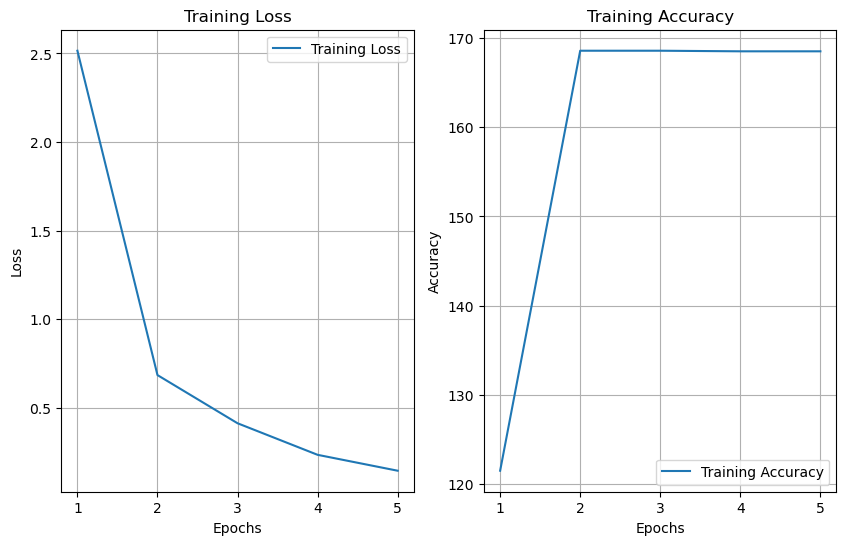

In [12]:
# plot loss graph
import matplotlib.pyplot as plt
import numpy as np

# Plot the loss graph
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, EPOCHS + 1), loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid()

accuracies = [accuracy.item() for accuracy in accuracies]

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, EPOCHS + 1), accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid()

plt.show()

In [ ]:
model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
tokenizer.save_pretrained(MODEL_SAVE_FOLDER_NAME)

**Inference**

In [ ]:
# Function to format the response and filter out the instruction from the response.
def postprocess(response):
    messages = response.split("Response:")
    if not messages:
        raise ValueError("Invalid template for prompt. The template should include the term 'Response:'")
    return "".join(messages[1:])
# Prompt for prediction
inference_prompt = "List 5 reasons why someone should learn to cook"
# Inference pipeline with the fine-tuned model
inf_pipeline =  pipeline('text-generation', model=model, tokenizer=tokenizer, max_length=256, trust_remote_code=True)
# inf_pipeline =  pipeline('text-generation', model=base_model, tokenizer=tokenizer, max_length=256, trust_remote_code=True)
# Format the prompt using the `prompt_template` and generate response 
response = inf_pipeline(prompt_template.format(instruction=inference_prompt))[0]['generated_text']
# postprocess the response
formatted_response = postprocess(response)
formatted_response